In [1]:
import numpy as np
import sys
import random
from phe import paillier

sys.path.append("../")

In [2]:
from federated.data.data_preprocessing import load_data, create_unbalanced_data

In [3]:
train_client_data, test_client_data = load_data(normalized=True, data_selector=create_unbalanced_data)

In [4]:
LIMIT = 100

In [5]:
def get_data_for_clients(source):
    data = []
    for client in range(1, 6):
        client_data = source[f"client_{client}"]
        X, y = client_data[0][:LIMIT], client_data[1][:LIMIT]
        client_data = [(X[i].reshape(-1, 1), y[i].reshape(-1, 1)) for i in range(len(X))]
        data.append(client_data)
    return data

In [23]:
class CrossEntropyCost:

    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    @staticmethod
    def delta(z, a, y):
        return (a-y)
    
class Network:
    
    def __init__(self, sizes, weights, biases, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = biases
        self.weights = weights
        self.cost = cost
    
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta):
            n = len(training_data)
            for j in range(epochs):
                random.shuffle(training_data)
                mini_batches = [
                    training_data[k:k+mini_batch_size]
                    for k in range(0, n, mini_batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(
                        mini_batch, eta, n)
        
    def update_mini_batch(self, mini_batch, eta, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
    
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def accuracy(self, data):
        results = [(np.argmax(self.feedforward(x)), y)
                       for (x, y) in data]
        return sum(int(y[x] == 1.0) for (x, y) in results)
    
    def total_cost(self, data):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            cost += self.cost.fn(a, y)/len(data)
        return cost

def sigmoid(z):
    return 1/(1+z)

def sigmoid_prime(z):
    return 1

In [24]:
class Client:
    def __init__(self, name, data, model):
        self.name = name
        self.data = data
        self.model = model
    
    def train(self):
        self.model.SGD(self.data, 10, 1, 0.1)

In [25]:
class Server:
    def __init__(self, model):
        self.model = model
    
    def aggregate(self, updates):
        weight_updates = [update.weights for update in updates]
        bias_updates = [update.biases for update in updates]

        self.model.weights = np.sum(weight_updates, axis=0) / len(weight_updates)
        self.model.biases = np.sum(bias_updates, axis=0) / len(bias_updates)

In [26]:
sizes = [186, 5]
weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(sizes[:-1], sizes[1:])]
biases = [np.random.randn(y, 1) for y in sizes[1:]]

In [27]:
keypair = paillier.generate_paillier_keypair(n_length=64)
pubkey, privkey = keypair

In [28]:
def encrypt(matrix):
    matrix_list = []
    for i in range(len(matrix)):
        arr1 = []
        for j in range(matrix[i].shape[0]):
            arr2 = []
            for k in range(matrix[i].shape[1]):
                arr2.append(pubkey.encrypt(matrix[i][j][k]))
        
            arr2 = np.array(arr2)
            arr1.append(arr2)

        arr1 = np.array(arr1)
        matrix_list.append(arr1)
    
    return matrix_list

In [29]:
weights_encrypted = encrypt(weights)
biases_encrypted = encrypt(biases)

In [30]:
model = Network(sizes, weights_encrypted, biases_encrypted)
server = Server(model)
data = get_data_for_clients(train_client_data)

In [31]:
for round_number in range(1):
    clients = [Client(f"client_{i+1}", data[i], server.model) for i in range(1)]
    
    for client in clients:
        client.train()
    
    updates = [client.model for client in clients]

    server.aggregate(updates)

    print(f"Round {round_number} completed :)")

ValueError: Integer needs to be within +/- 4280245162156257328 but got 295147905179352825856

In [15]:
weights_encrypted = client.model.weights
weights_encrypted = np.squeeze(weights_encrypted)

In [16]:
weights_decrypted = []
for i in range(weights_encrypted.shape[0]):
    arr = []
    for j in range(weights_encrypted.shape[1]):
        arr.append(privkey.decrypt(weights_encrypted[i][j]))
    
    arr = np.array(arr)
    weights_decrypted.append(arr)

weights_decrypted = np.array(weights_decrypted)

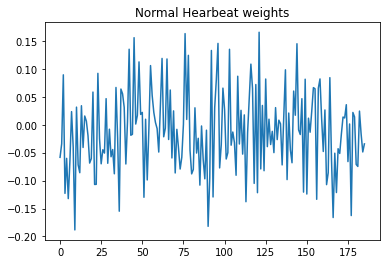

In [22]:
import matplotlib.pyplot as plt

plt.title("Normal Hearbeat weights")

plt.plot(weights_decrypted[0, :])

plt.show()

In [26]:
weights_encrypted[0][0].ciphertext(be_secure=False)

4538225244256794672760022561830999251297429809719071389073411528427589724322547889234808007195010498605676375975956684618752224602094403958068574995693479978414204977253971836592518915100070281572391869545884518003797543356286961873844555783106946557142775420849781354231561579762360399199868895063234147304163661649651697202031179763018411407821479478009097438269937703164939886651256146805924722760888945676504950160262946014863059126527443857673865824544134449645309792037872869231915035545560396382099939881319075694936137610240399400812440920974219255618135241550526166224578769279401457291424038518174872074069